## Code for figure 4
The notebook here generates the panels associated with Fig. 4. Note these are the raw panels that are then edited for tick labels/marks to form consistent panels.

In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)


# for rasterized=True
from matplotlib.backends.backend_pdf import PdfPages



In [2]:
from afrc import AnalyticalFRC
from sparrow import Protein
from shephard import interfaces, apis

from shephard.exceptions import ProteinException


import protfasta

In [3]:

# define the directory where the proteome-wide data are held. These data can be obtained from
# https://github.com/holehouse-lab/shephard-data/tree/main/data/proteomes/human
shephard_data_dir = ''


In [4]:
# read in and annotate the human proteome with IDRs
human_proteome = apis.uniprot.uniprot_fasta_to_proteome(f'{shephard_data_dir}/human_proteome_clean.fasta')

# IDRs_with_properties_v2.tsv was generated using the notebook build_idr_properties.ipynb
interfaces.si_domains.add_domains_from_file(human_proteome, 'IDRs_with_properties_v2.tsv')

interfaces.si_protein_attributes.add_protein_attributes_from_file(human_proteome, f'{shephard_data_dir}/shprd_protats_gene_names.tsv')


### Write out IDROme as a stand-alone FASTA file

In [5]:
# save human IDROME for analysis
human_idrome = {}
for d in human_proteome.domains:
    human_idrome[d.protein.name + " | " + d.domain_name.replace("IDR_","IDR ").replace("_","-")] = d.sequence
    
protfasta.write_fasta(human_idrome, 'human_idrs.fasta')

### Write out IDROme as a CSV
Next, we generate a CSV file that contains our version of the human IDR-ome. Specifically, this makes it easy for anyone to look through and see if their IDR of choice is 



In [6]:
np.max([len(x) for x in human_proteome.domains])

12457

In [7]:
fh = open('IDRome_all.csv','w')



out_string = ''
out_string += "Unique ID, "
out_string += "Gene name, "
out_string += "UniProt ID, "
out_string += "UniProt header, "
out_string += "IDR start, "
out_string += "IDR end, "
out_string += "IDR len, "
out_string += "Rg (A), "
out_string += "Normalized Rg, "
out_string += "Re (A), "
out_string += "Normalized Re, "
out_string += "asphericity, "
out_string += "FCR, "
out_string += "NCPR, "
out_string += "kappa, "
out_string += "frac_negative, "
out_string += "fract_positive, "
out_string += "fract_aro, "
out_string += "fract_pro, "
out_string += "fract_polar, "
out_string += "fract_ali, "
out_string += "sequence\n"

fh.write(out_string)

for p in human_proteome:
    for d in p.domains:
        
        out_string = ''
        
        
        out_string += f"{p.unique_ID}_{d.start}_{d.end}, "
        
        
        try:
            out_string += f"{p.attribute('gene_name')}, "
        except ProteinException:
            out_string += f", "
            
        out_string += f"{p.unique_ID}, "
        out_string += f"{p.name.replace(',',';')}, "
        out_string += f"{d.start}, "
        out_string += f"{d.end}, "
        out_string += f"{len(d.sequence)}, "
        
        out_string += f"{round(float(d.attribute('radius_of_gyration')),2)}, "
        out_string += f"{round(float(d.attribute('rg_afrc_norm')),2)}, "
        out_string += f"{round(float(d.attribute('end_to_end_distance')),2)}, "
        out_string += f"{round(float(d.attribute('re_afrc_norm')),2)}, "
        out_string += f"{round(float(d.attribute('asphericity')),2)}, "
        
        
        local_protein = Protein(d.sequence)
        out_string += f"{round(local_protein.FCR,3)}, "
        out_string += f"{round(local_protein.NCPR,3)}, "
        out_string += f"{round(local_protein.kappa,3)}, "
        out_string += f"{round(local_protein.fraction_negative,3)}, "
        out_string += f"{round(local_protein.fraction_positive,3)}, "
        out_string += f"{round(local_protein.fraction_aromatic,3)}, "
        out_string += f"{round(local_protein.fraction_proline,3)}, "
        out_string += f"{round(local_protein.fraction_polar,3)}, "
        out_string += f"{round(local_protein.fraction_aliphatic,3)}, "
        out_string += f"{d.sequence}\n"
        fh.write(out_string)
        
        
        


In [16]:
# cast all attributes to floats
all_attribute_names = list(human_proteome.domains[0]._attributes.keys())

valid_idrs = []
for d in human_proteome.domains:
    
    for att_name in all_attribute_names:
        if att_name in d.attributes:        
            d.add_attribute(att_name, float(d.attribute(att_name)),safe=False)
        
valid_idrs = []
precomputed = {}
for d in human_proteome.domains:
    if len(d) > 35 and len(d) < 3000:
        if 'radius_of_gyration' in d.attributes:
            valid_idrs.append(d)
            d.add_attribute('sparrow',Protein(d.sequence))


## IDR count panel
Remember this is after filtering for only IDRs between 35 and 700 residues.

In [30]:
idrs_under_3000 = [j for j in [i for i in human_proteome.domains if len(i) < 3000] if len(j) > 35]
idrs_over_3000 = [i for i in human_proteome.domains if len(i) > 3000]

In [47]:
print(len(idrs_under_3000))
idrs_over_3000
print(len(valid_idrs))

20812
20812


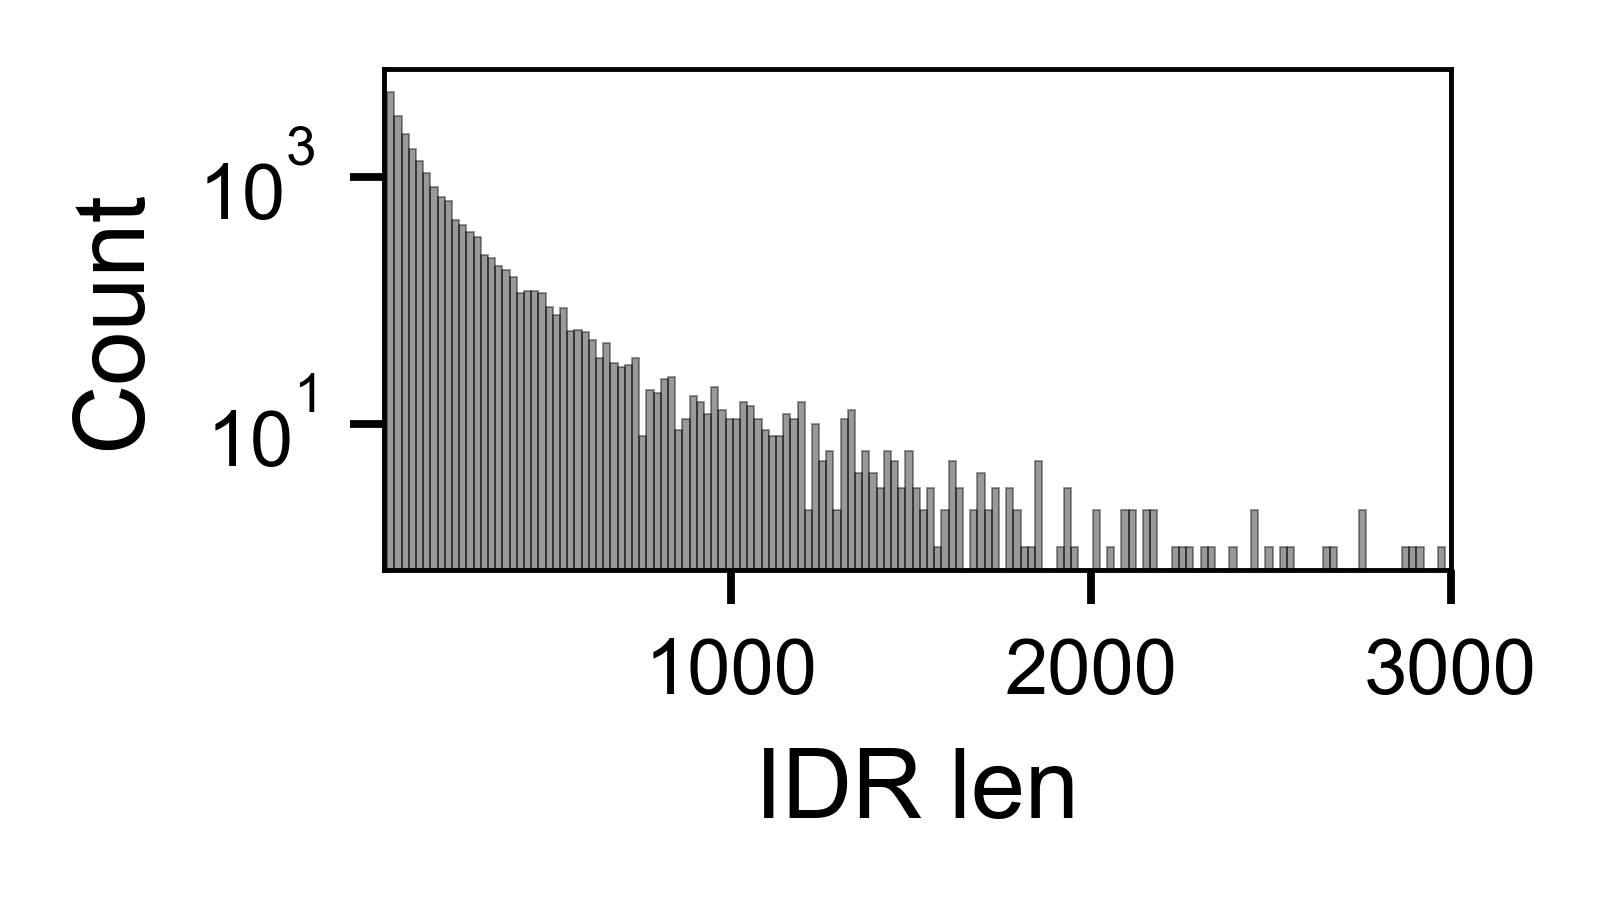

In [33]:
all_lengths = [len(x) for x in valid_idrs]

figure(None, (2.4,1.4), dpi=350)
ax = plt.gca()
bin_width=20
bins = np.arange(35, 20000, bin_width)

[a,b] = np.histogram(all_lengths, bins=bins)
plt.bar(bins[1:], a, width=bin_width*1, color='k', alpha=0.4, linewidth=0.2, edgecolor='k') 
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.yscale('log')
plt.xlim([35, 3000])
plt.ylabel('Count', fontsize=10)
plt.xlabel('IDR len', fontsize=10)

plt.plot([0.7,1.4],[1300,1300], color='k', linewidth=0.8)
plt.tight_layout()
plt.savefig('figures/idr_count.pdf')


## Compute local properties on valid IDRs
The cell below extracts out core parameters for easy plotting

In [34]:
all_nu = np.array([d.attribute('scaling_exponent') for d in valid_idrs])
all_rg_norm = np.array([d.attribute('rg_afrc_norm') for d in valid_idrs])
all_re_norm = np.array([d.attribute('re_afrc_norm') for d in valid_idrs])
all_rg    = [d.attribute('radius_of_gyration_sn') for d in valid_idrs]
all_re    = [d.attribute('end_to_end_distance_sn') for d in valid_idrs]
all_asph = [d.attribute('asphericity') for d in valid_idrs]


all_aro   = [d.attribute('sparrow').fraction_aromatic for d in valid_idrs]
all_pro   = [d.attribute('sparrow').fraction_proline for d in valid_idrs]
all_fcr_pro   = [d.attribute('sparrow').FCR + d.attribute('sparrow').fraction_proline for d in valid_idrs]
all_abs_ncpr_pro   = [abs(d.attribute('sparrow').NCPR) + d.attribute('sparrow').fraction_proline for d in valid_idrs]

all_abs_ncpr   = [abs(d.attribute('sparrow').NCPR)  for d in valid_idrs]

all_fcr   = [d.attribute('sparrow').FCR for d in valid_idrs]
all_kappa = [d.attribute('sparrow').kappa for d in valid_idrs]

all_lengths = [len(d) for d in valid_idrs]

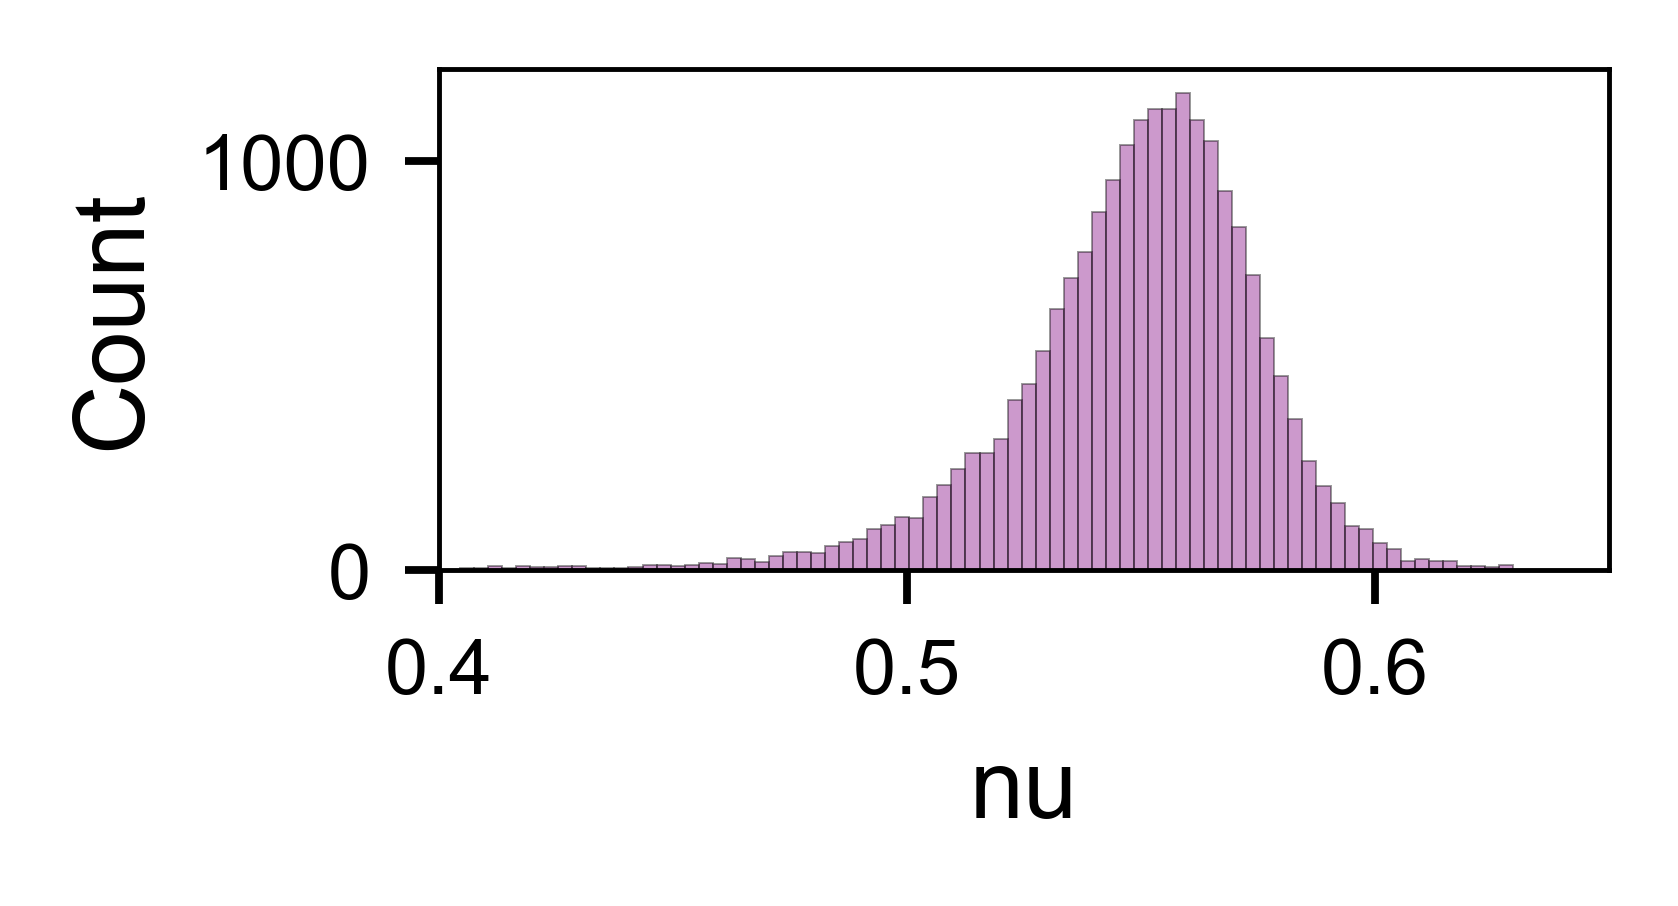

In [35]:
figure(None, (2.5,1.4), dpi=350)
bin_width=0.003
bins = np.arange(0.4,0.63,bin_width)

[a,b] = np.histogram(all_nu,bins=bins)
plt.bar(bins[1:], a, width=bin_width*1, color='purple', alpha=0.4, linewidth=0.2, edgecolor='k') 
#plt.yscale('log')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.xlim([0.4,0.65])
plt.ylabel('Count', fontsize=10)
plt.xlabel('nu', fontsize=10)
plt.tight_layout()
plt.savefig('figures/human_idrs_nu_histo_v2.pdf')

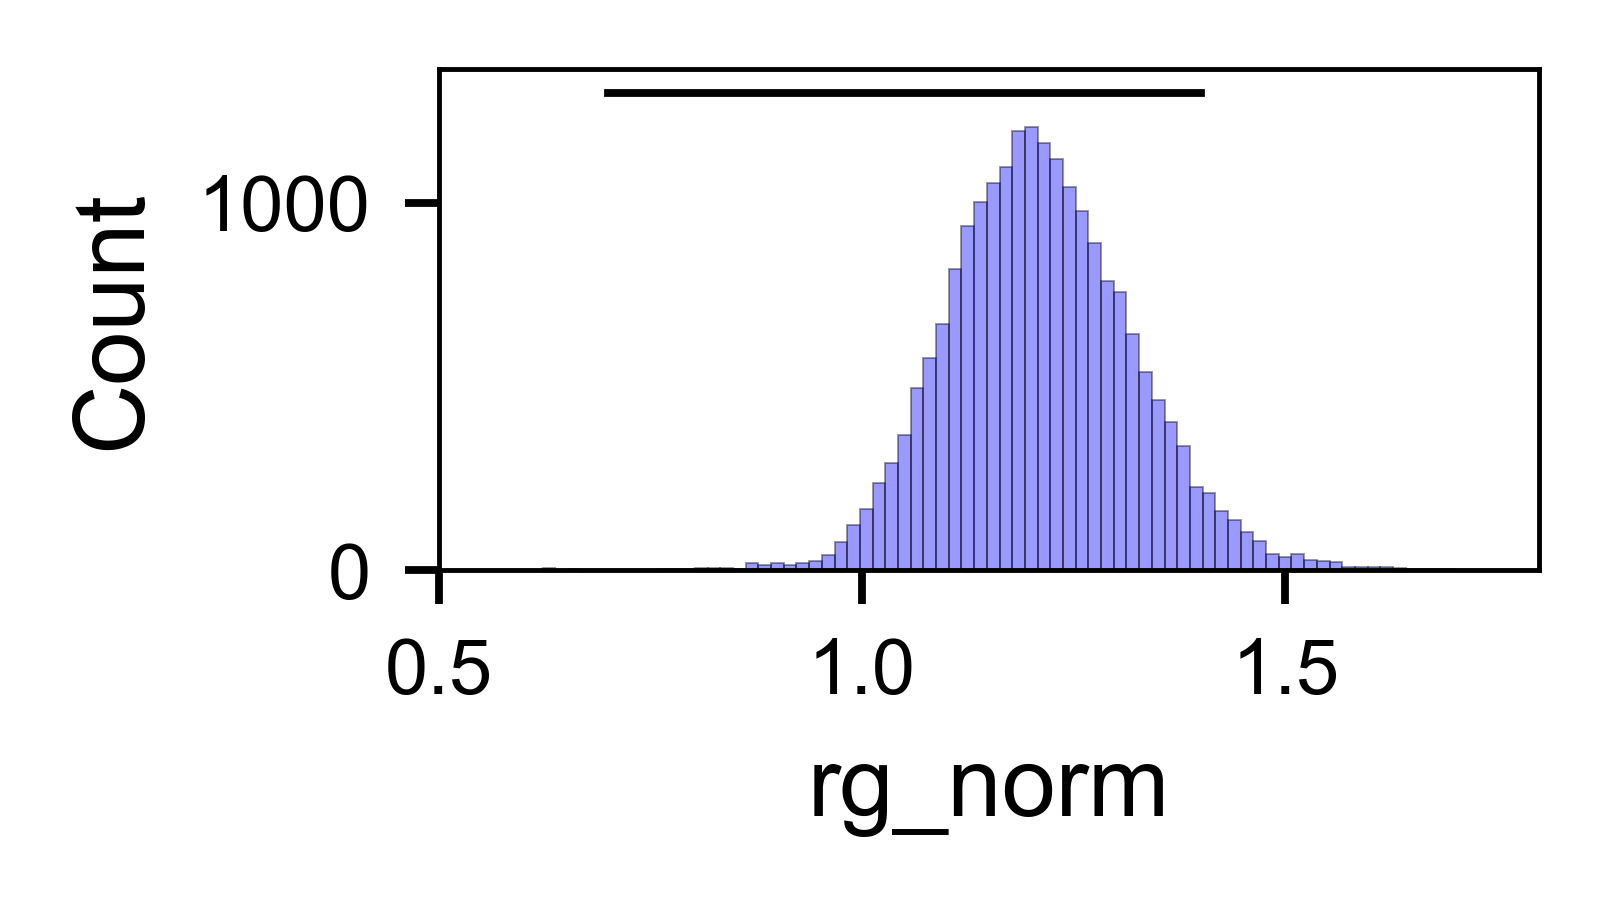

In [36]:
figure(None, (2.4,1.4), dpi=350)
ax = plt.gca()
bin_width=0.015
bins = np.arange(0.3,2.5,bin_width)

[a,b] = np.histogram(all_rg_norm, bins=bins)
plt.bar(bins[1:], a, width=bin_width*1, color='blue', alpha=0.4, linewidth=0.2, edgecolor='k') 
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.xlim([0.5,1.8])
plt.ylabel('Count', fontsize=10)
plt.xlabel('rg_norm', fontsize=10)

plt.plot([0.7,1.4],[1300,1300], color='k', linewidth=0.8)
plt.tight_layout()
plt.savefig('figures/human_idrs_rg_norm_histor_v2.pdf')

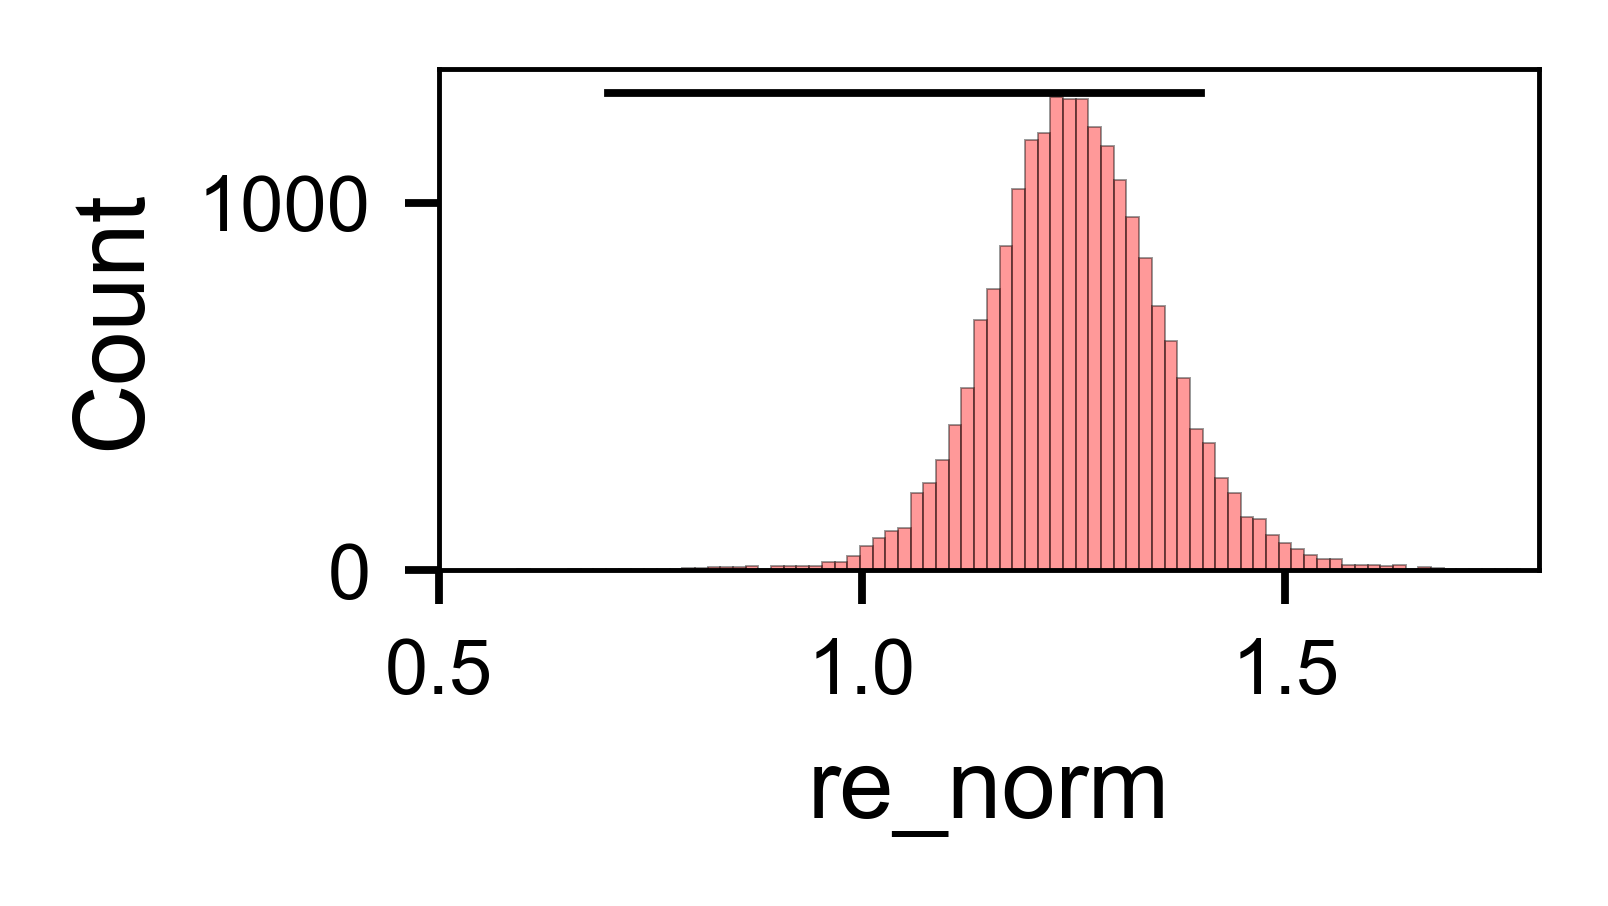

In [37]:
figure(None, (2.4,1.4), dpi=350)
ax = plt.gca()
bin_width=0.015
bins = np.arange(0.3,2.5,bin_width)

[a,b] = np.histogram(all_re_norm,bins=bins)
plt.bar(bins[1:], a, width=bin_width*1, color='red', alpha=0.4, linewidth=0.2, edgecolor='k') 
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.xlim([0.5,1.8])
plt.ylabel('Count', fontsize=10)
plt.xlabel('re_norm', fontsize=10)

plt.plot([0.7,1.4],[1300,1300], color='k', linewidth=0.8)
plt.tight_layout()
plt.savefig('figures/human_idrs_re_norm_histor_v2.pdf')

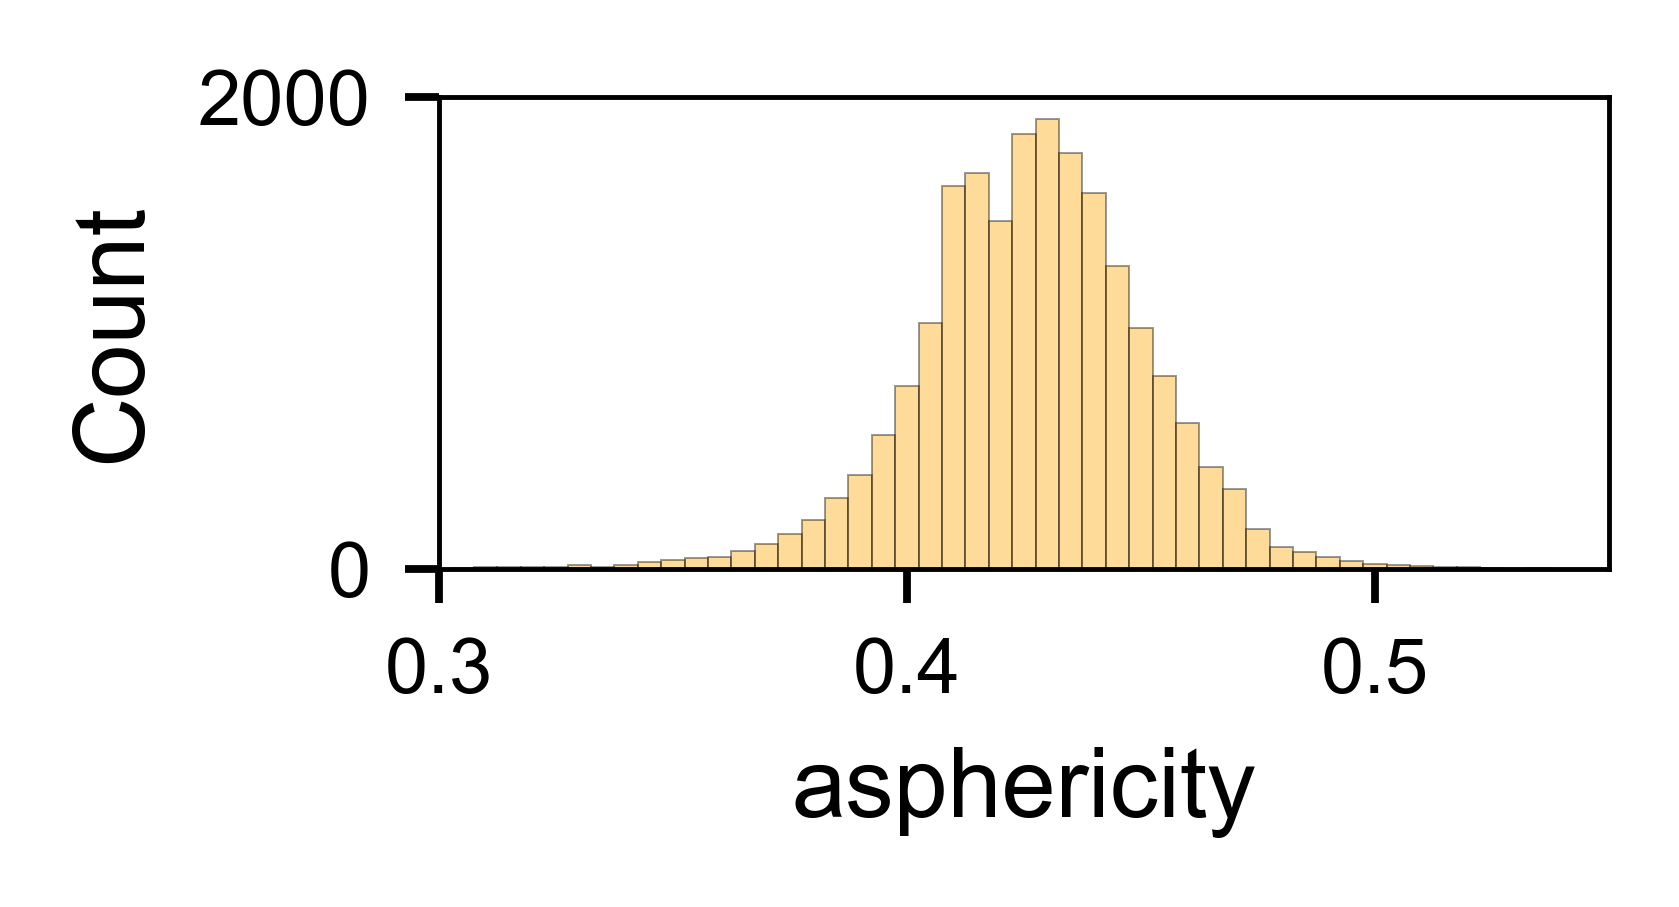

In [38]:
figure(None, (2.5,1.4), dpi=350)
bin_width=0.005
bins = np.arange(0,1,bin_width)

[a,b] = np.histogram(all_asph,bins=bins)
plt.bar(bins[1:], a, width=bin_width*1, color='orange', alpha=0.4, linewidth=0.2, edgecolor='k') 
#plt.yscale('log')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.xlim([0.3,0.55])
plt.ylabel('Count', fontsize=10)
plt.xlabel('asphericity', fontsize=10)
plt.tight_layout()
plt.savefig('figures/human_idrs_asphericity_v2.pdf')

0.5570144591708255 2.3343287053055097


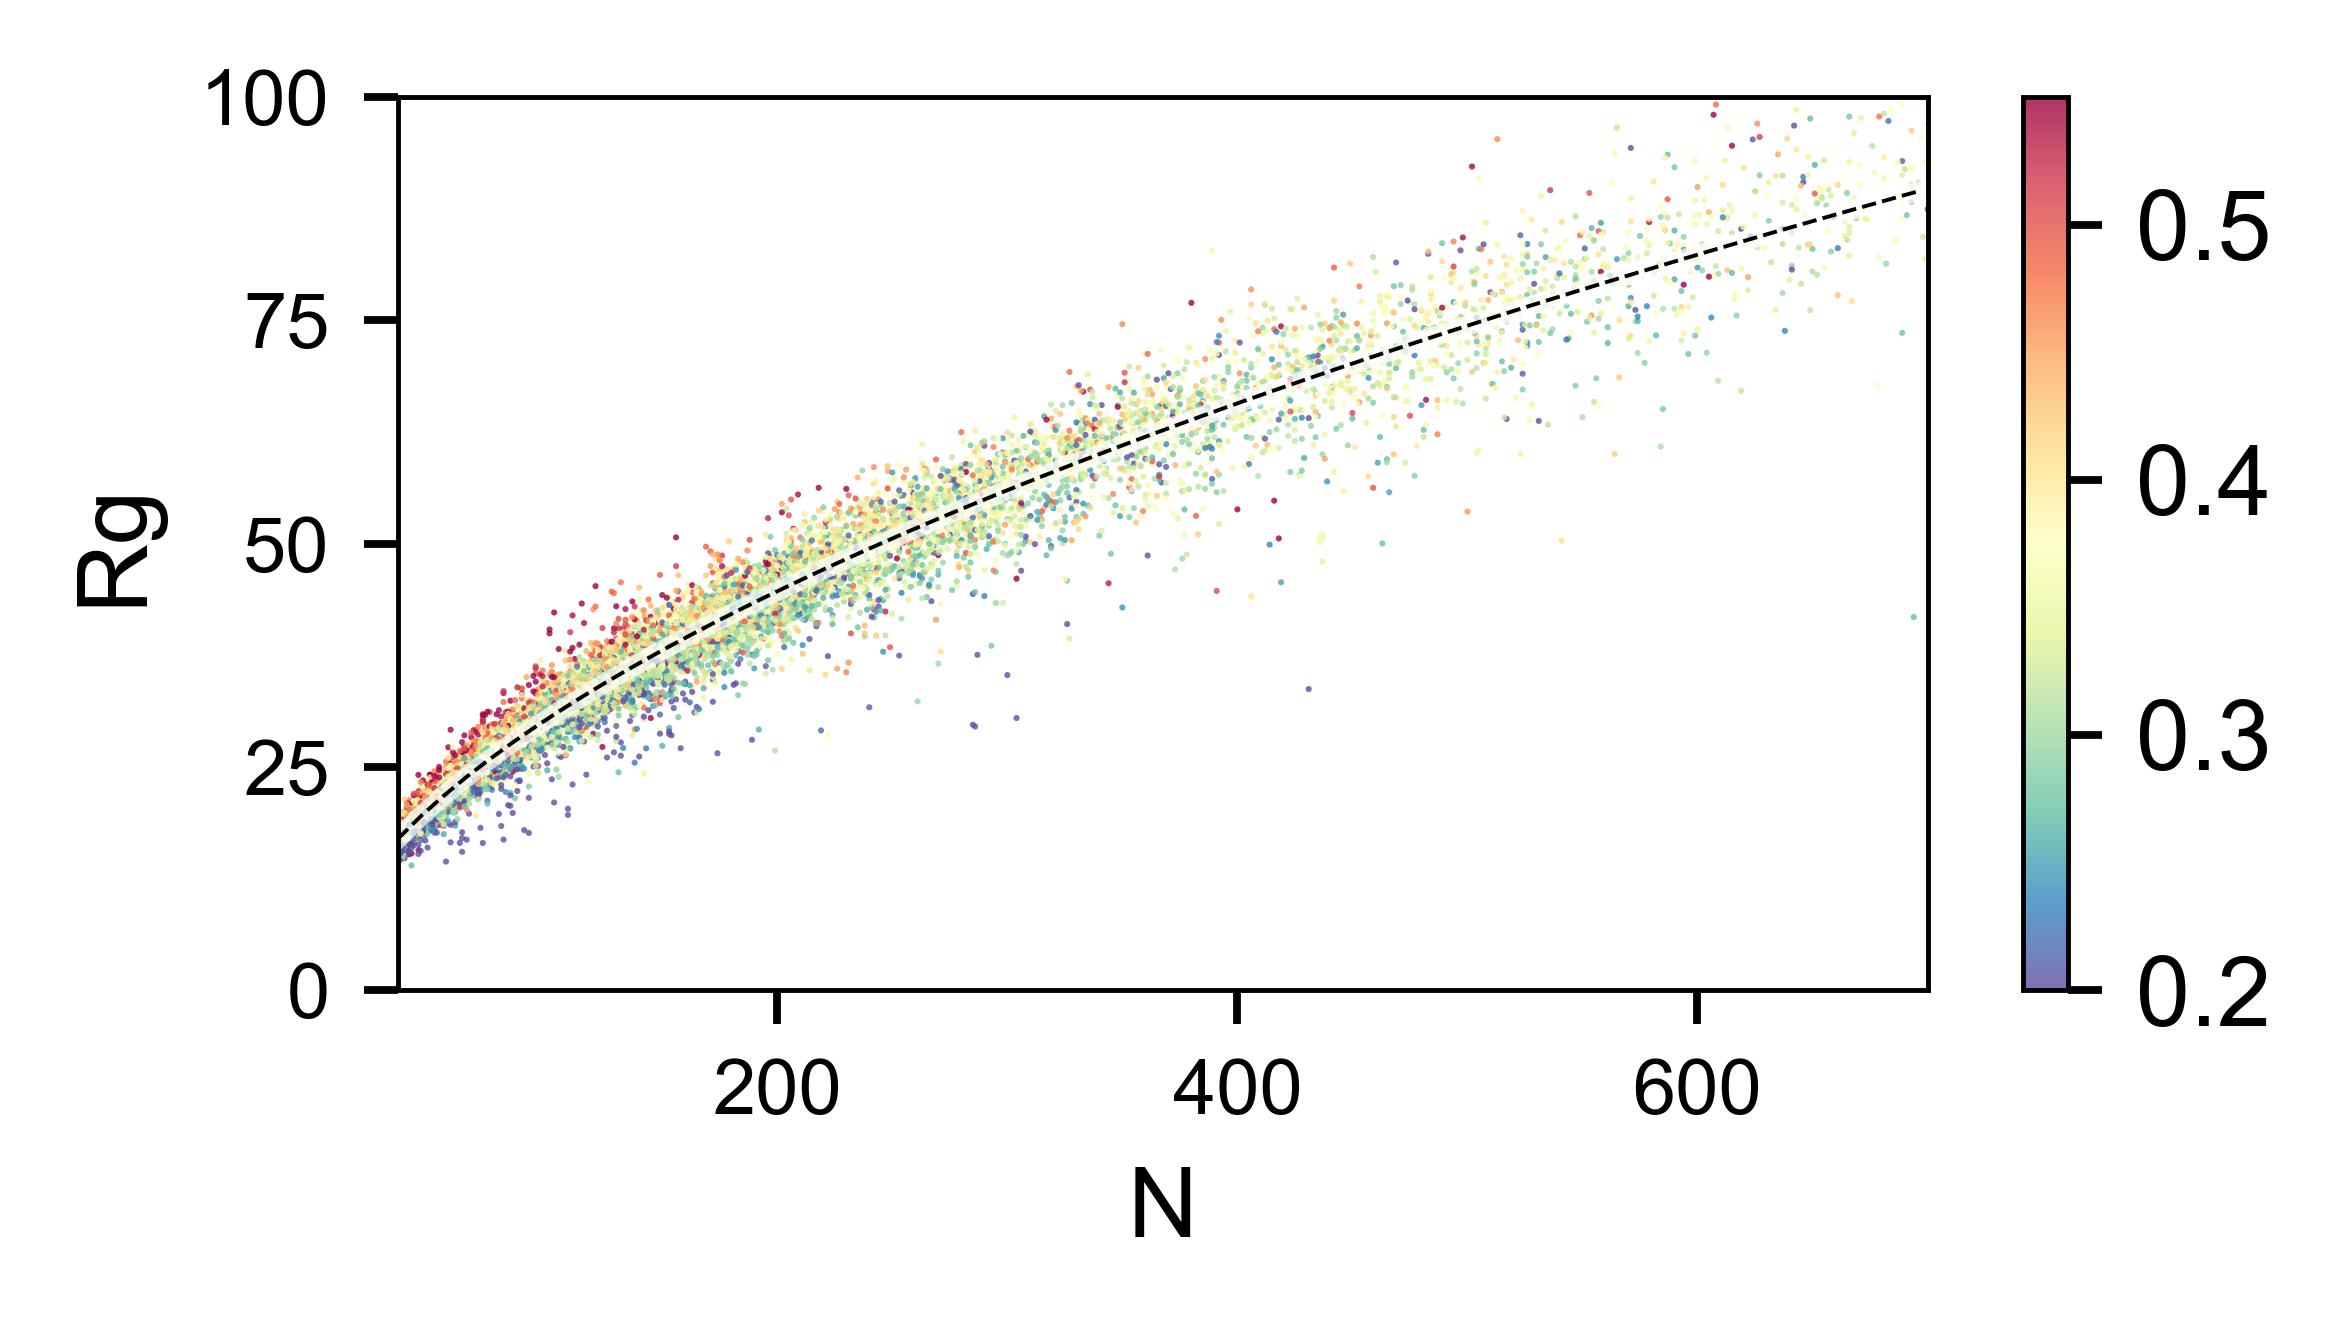

In [39]:
fig = figure(None, (3.5,2.), dpi=350)
plt.scatter(all_lengths, all_rg, c=all_fcr_pro, s=0.4, alpha=0.8, lw=0, cmap='Spectral_r', vmin=0.2, vmax=0.55, rasterized=True)
plt.ylim([0,100])
plt.xlim([35,700])

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

fit = np.polyfit(np.log(all_lengths), np.log(all_rg),1)
xvals = np.arange(35,700,10)
yvals = np.power(xvals,fit[0])*np.exp(fit[1])
plt.plot(xvals,yvals, '-',color='w', lw=2, alpha=0.7)
plt.plot(xvals,yvals, '--',color='k', lw=0.4)


plt.ylabel('Rg', fontsize=10)
plt.xlabel('N', fontsize=10)
print(fit[0], np.exp(fit[1]))
plt.colorbar()
plt.tight_layout()

with PdfPages('figures/human_idrs_n_vs_rg_fcr_pro_colored_v2.pdf') as pdf:
    pdf.savefig(fig, dpi=950)

0.5570144591708255 2.3343287053055097
0.5469714491639438


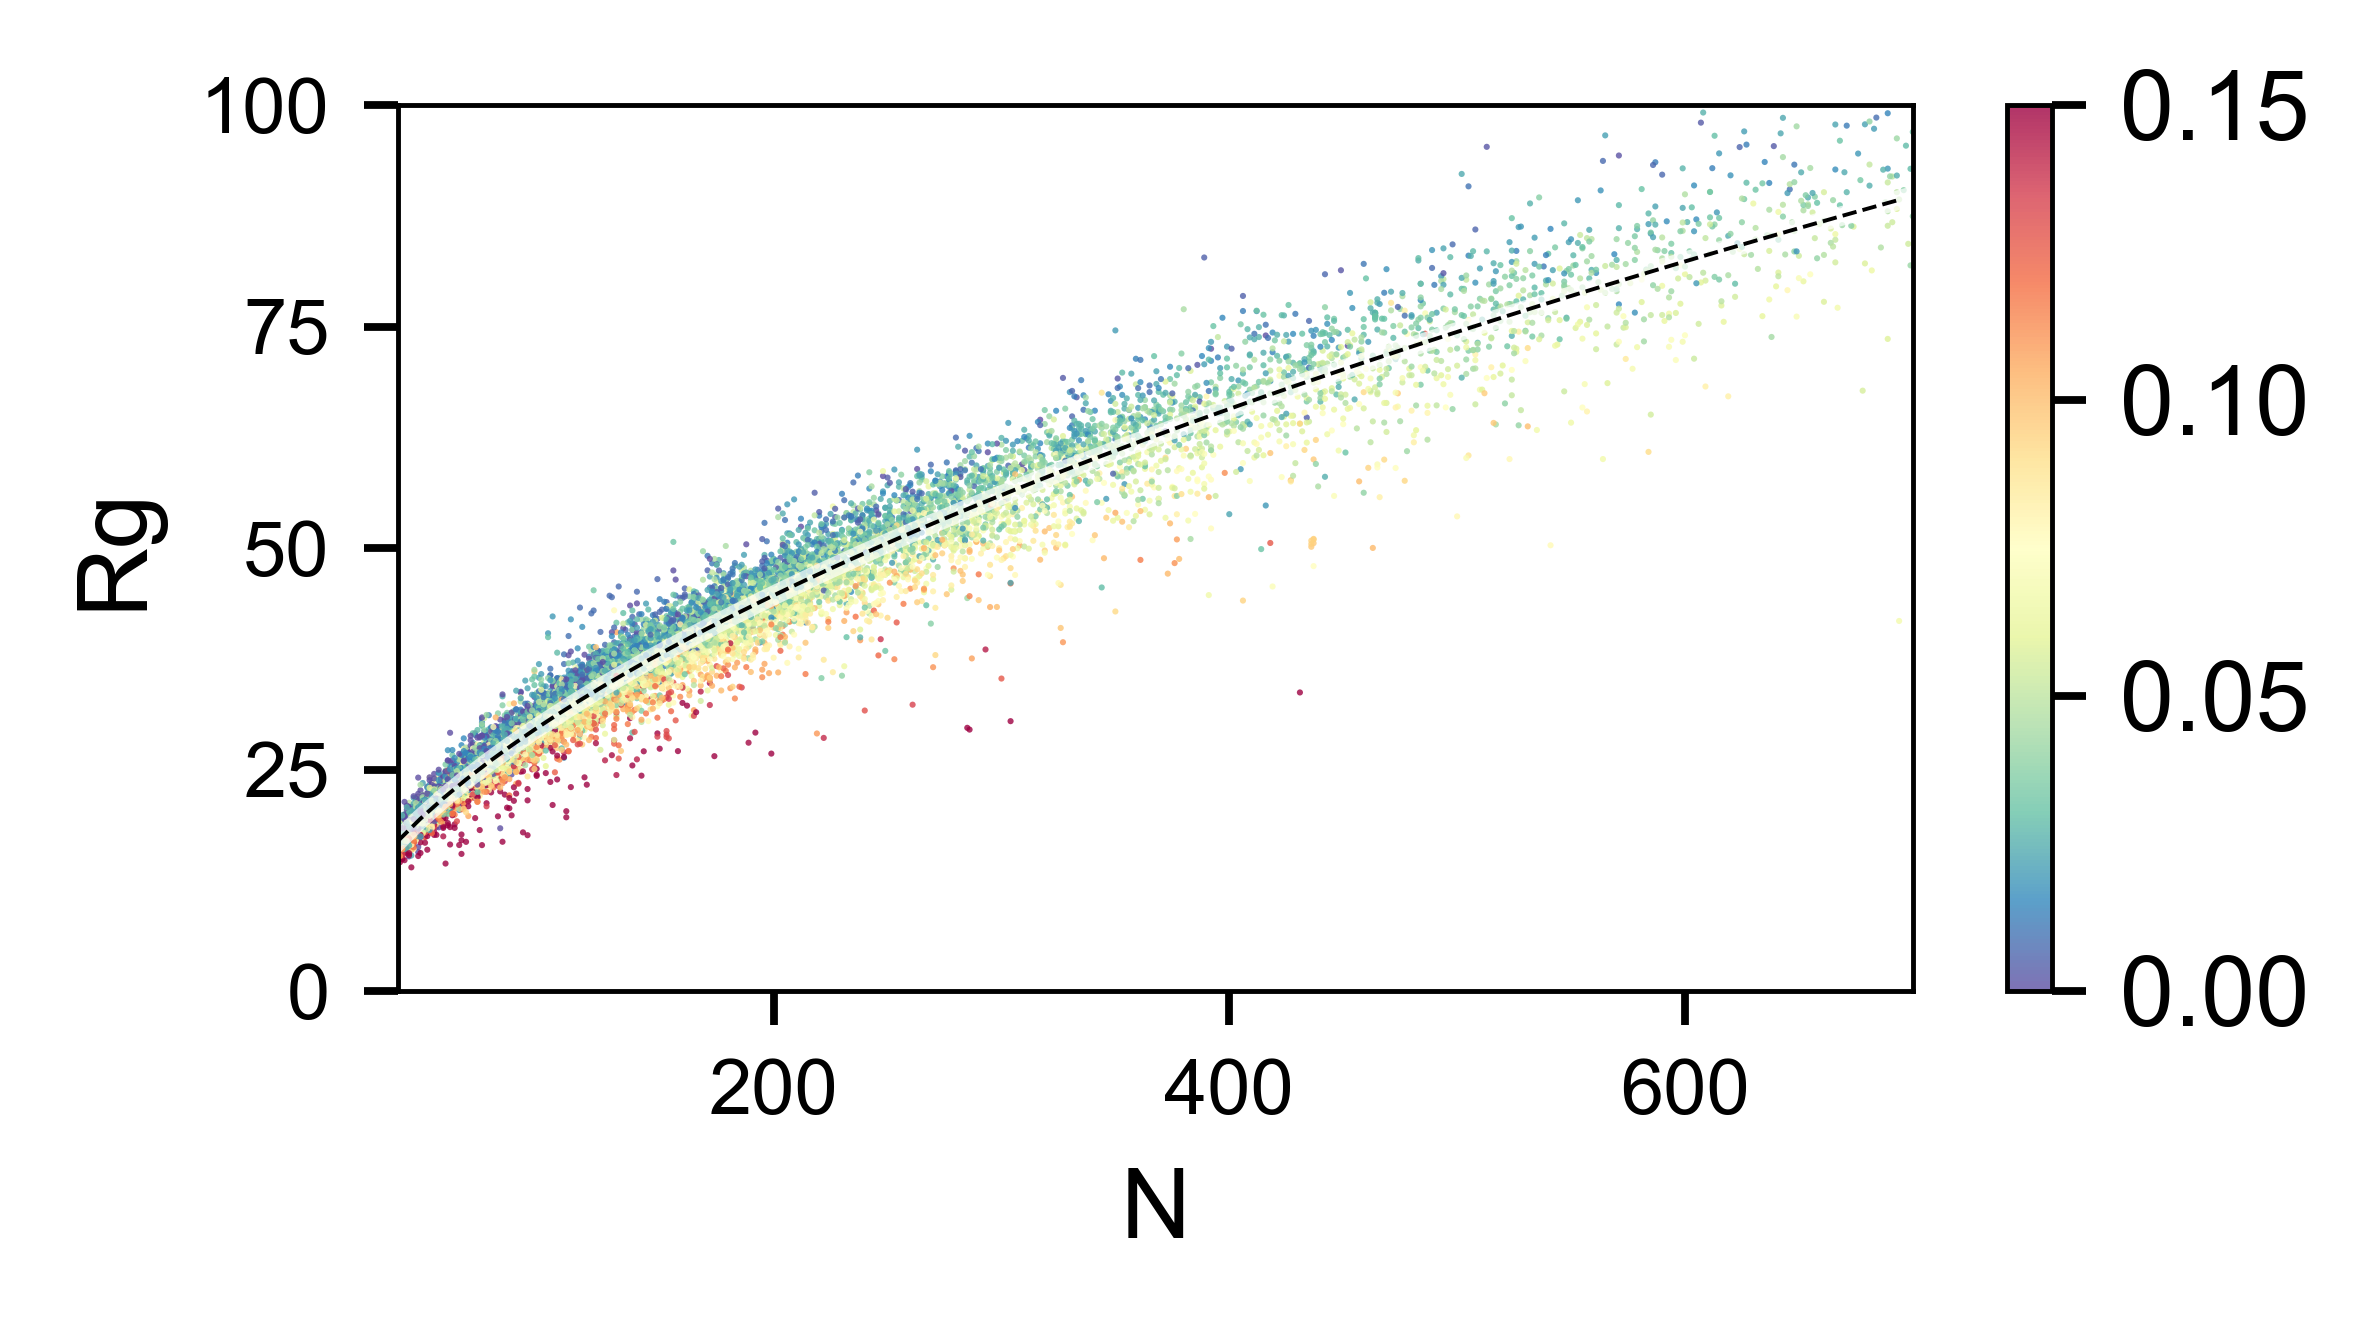

In [40]:
fig = figure(None, (3.5,2.), dpi=350)
plt.scatter(all_lengths, all_rg, c=all_aro, s=0.4, alpha=0.8, lw=0, cmap='Spectral_r', vmin=0, vmax=0.15, rasterized=True)
plt.ylim([0,100])
plt.xlim([35,700])

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

fit = np.polyfit(np.log(all_lengths), np.log(all_rg),1)
xvals = np.arange(35,700,10)
yvals = np.power(xvals,fit[0])*np.exp(fit[1])
plt.plot(xvals,yvals, '-',color='w', lw=2, alpha=0.7)
plt.plot(xvals,yvals, '--',color='k', lw=0.4)
plt.ylabel('Rg', fontsize=10)
plt.xlabel('N', fontsize=10)
print(fit[0], np.exp(fit[1]))
print(np.mean(all_nu))
plt.colorbar()
plt.tight_layout()
plt.tight_layout()
with PdfPages('figures//human_idrs_n_vs_rg_aro_colored_v2.pdf') as pdf:
    pdf.savefig(fig, dpi=950)





In [41]:
compact_pro = []
compact_all_abs_ncpr = []
compact_rg_norm = []

for idx in range(len(all_rg_norm)):
    if all_rg_norm[idx] < 1.0317:
        compact_pro.append(all_pro[idx])
        compact_all_abs_ncpr.append(all_abs_ncpr[idx])
        compact_rg_norm.append(all_rg_norm[idx])
        
print(len(compact_pro))        

expanded_pro = []
expanded_all_abs_ncpr = []
expanded_rg_norm = []

for idx in range(len(all_rg_norm)):
    if all_rg_norm[idx] > 1.3776:
        expanded_pro.append(all_pro[idx])
        expanded_all_abs_ncpr.append(all_abs_ncpr[idx])
        expanded_rg_norm.append(all_rg_norm[idx])
        
print(len(expanded_pro))        




1019
1224


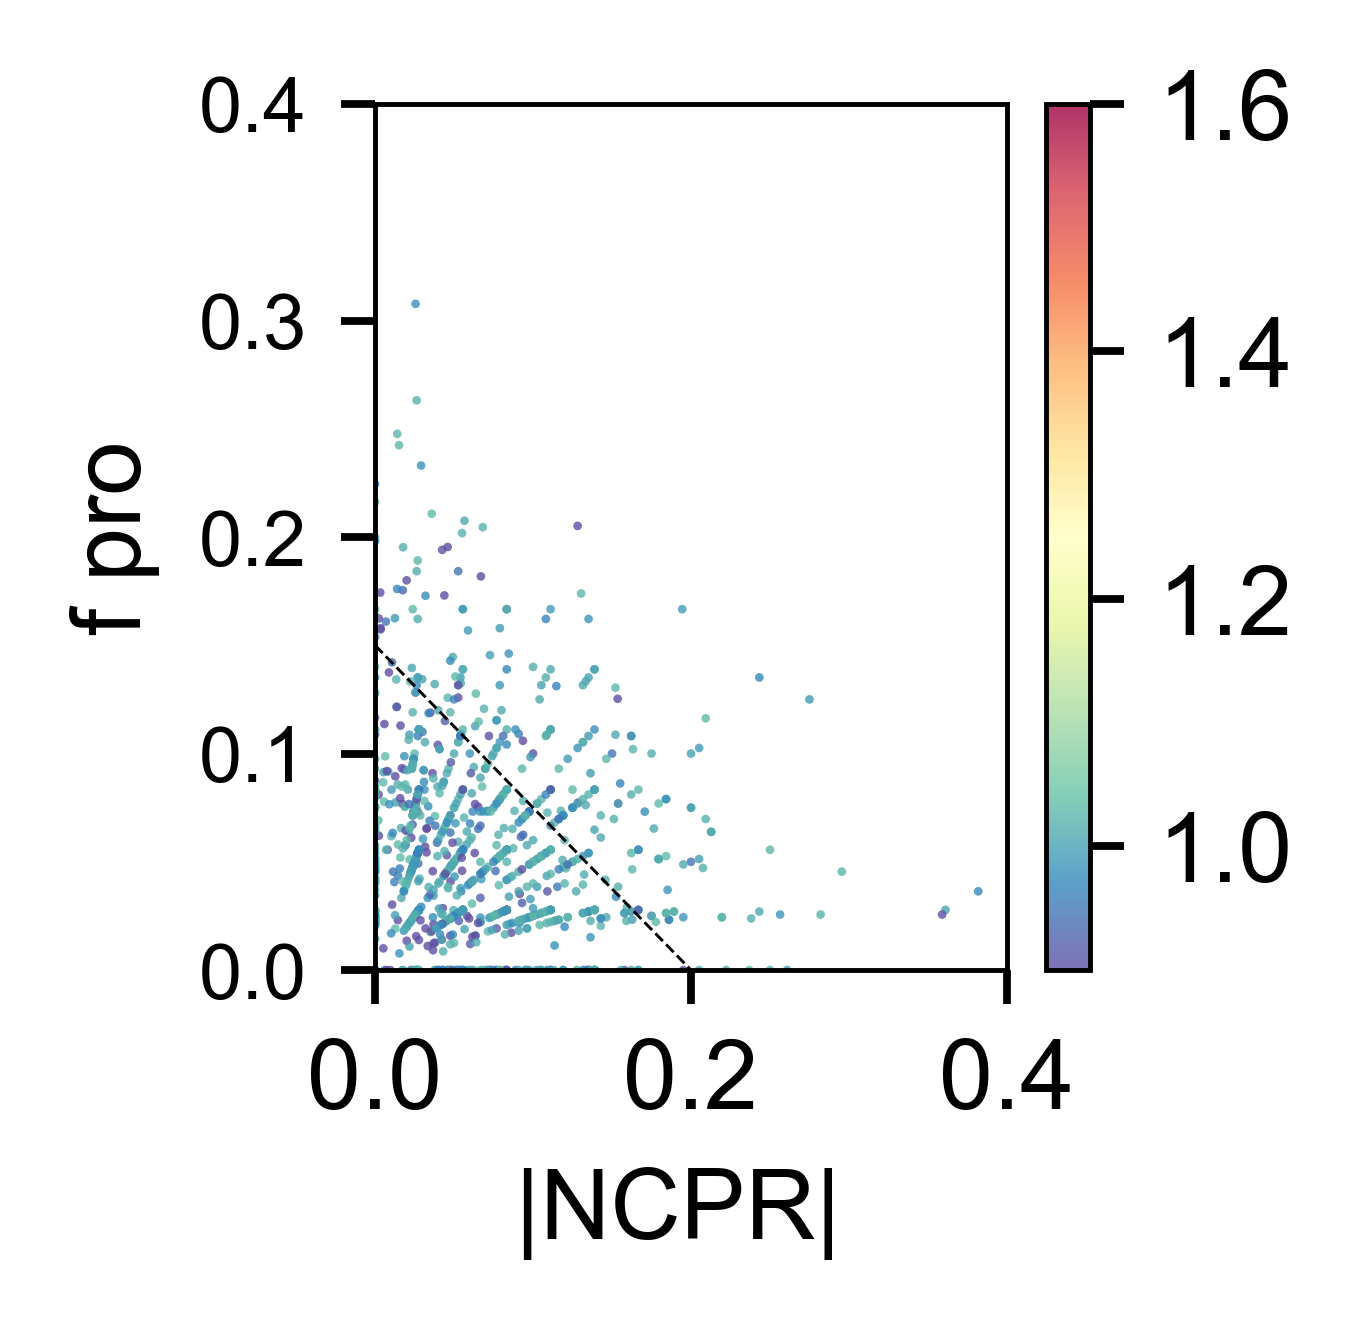

In [42]:

fig = figure(None, (2.,2.), dpi=350)

plt.scatter(compact_all_abs_ncpr, compact_pro,  c=compact_rg_norm, s=0.8, alpha=0.8, lw=0, cmap='Spectral_r', vmin=0.9, vmax=1.6, rasterized=True)

plt.xlim([0,0.4])
plt.ylim([0,0.4])
plt.xlabel('|NCPR| ', fontsize=10)
plt.ylabel('f pro', fontsize=10)
plt.yticks(fontsize=8)
plt.plot([0,0.2],[0.15,0],'--k', linewidth=0.3)

plt.colorbar()
plt.tight_layout()

with PdfPages('figures/compact_idrs_1000_v2.pdf') as pdf:
    pdf.savefig(fig, dpi=950)





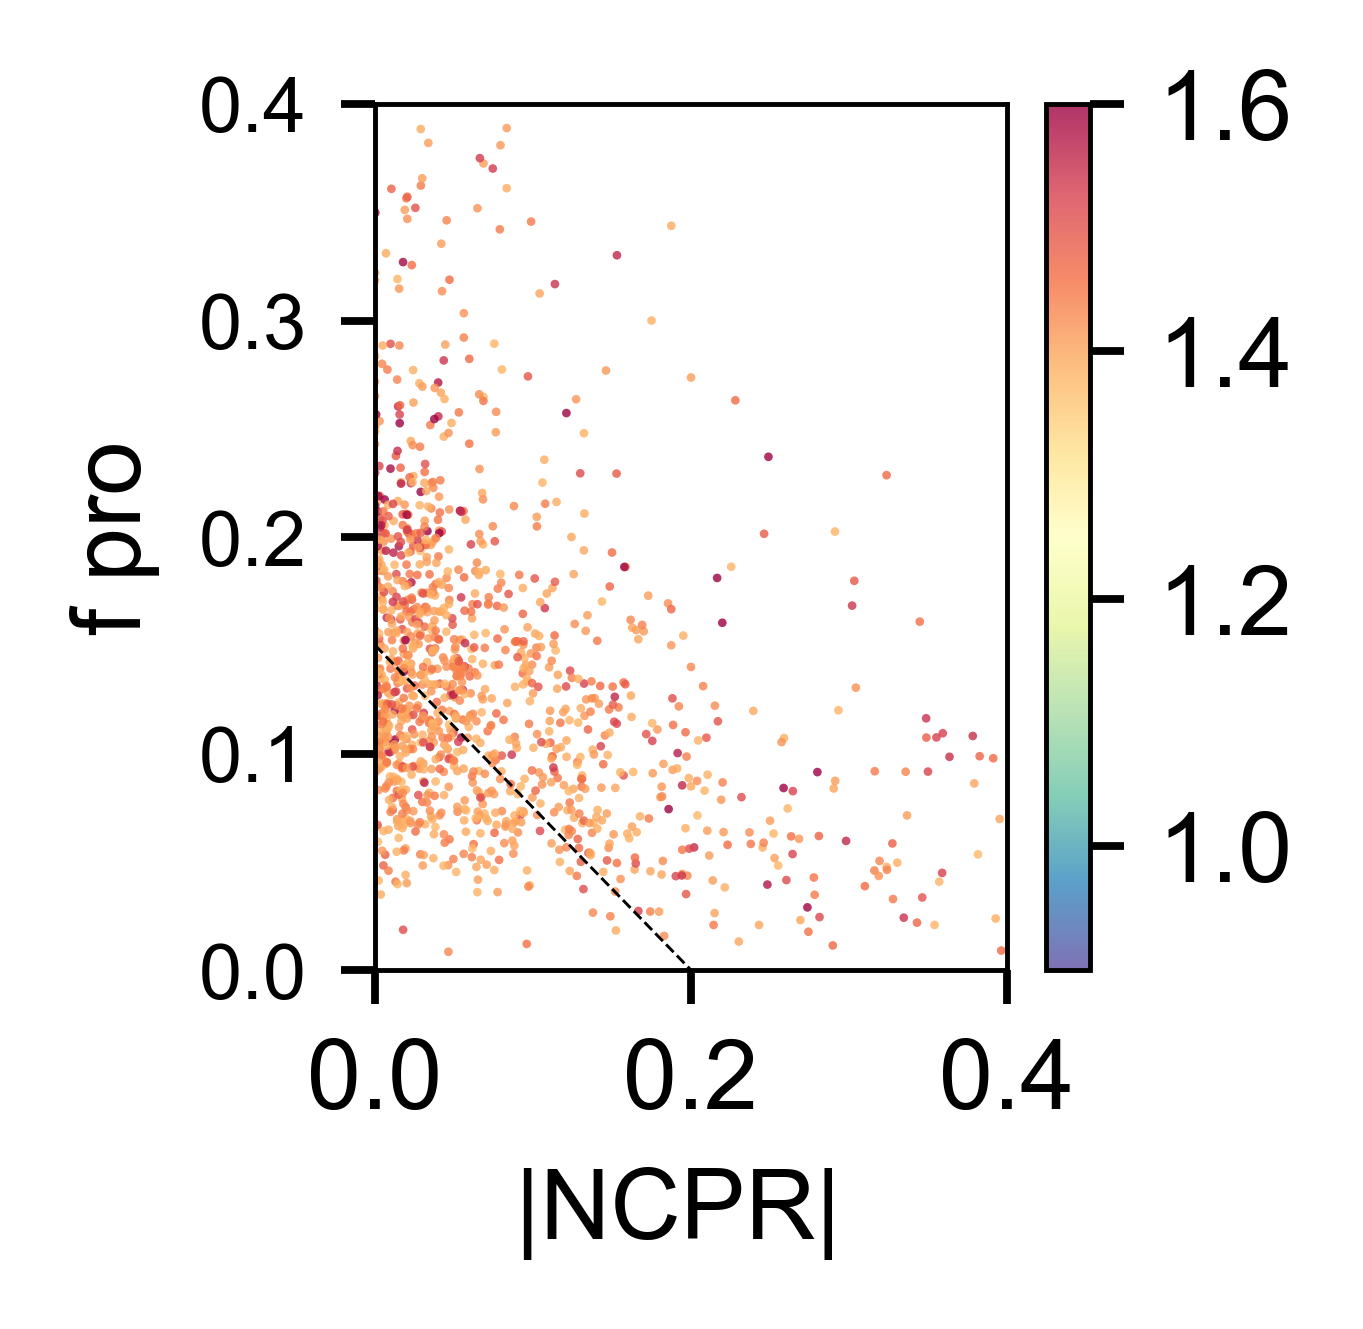

In [43]:

fig = figure(None, (2.,2.), dpi=350)

plt.scatter(expanded_all_abs_ncpr, expanded_pro,  c=expanded_rg_norm, s=0.8, alpha=0.8, lw=0, cmap='Spectral_r', vmin=0.9, vmax=1.6, rasterized=True)

plt.xlim([0,0.4])
plt.ylim([0,0.4])
plt.xlabel('|NCPR| ', fontsize=10)
plt.ylabel('f pro', fontsize=10)
plt.yticks(fontsize=8)
plt.plot([0,0.2],[0.15,0],'--k', linewidth=0.3)
plt.colorbar()
plt.tight_layout()

with PdfPages('figures/expanded_idrs_1000_v2.pdf') as pdf:
    pdf.savefig(fig, dpi=950)





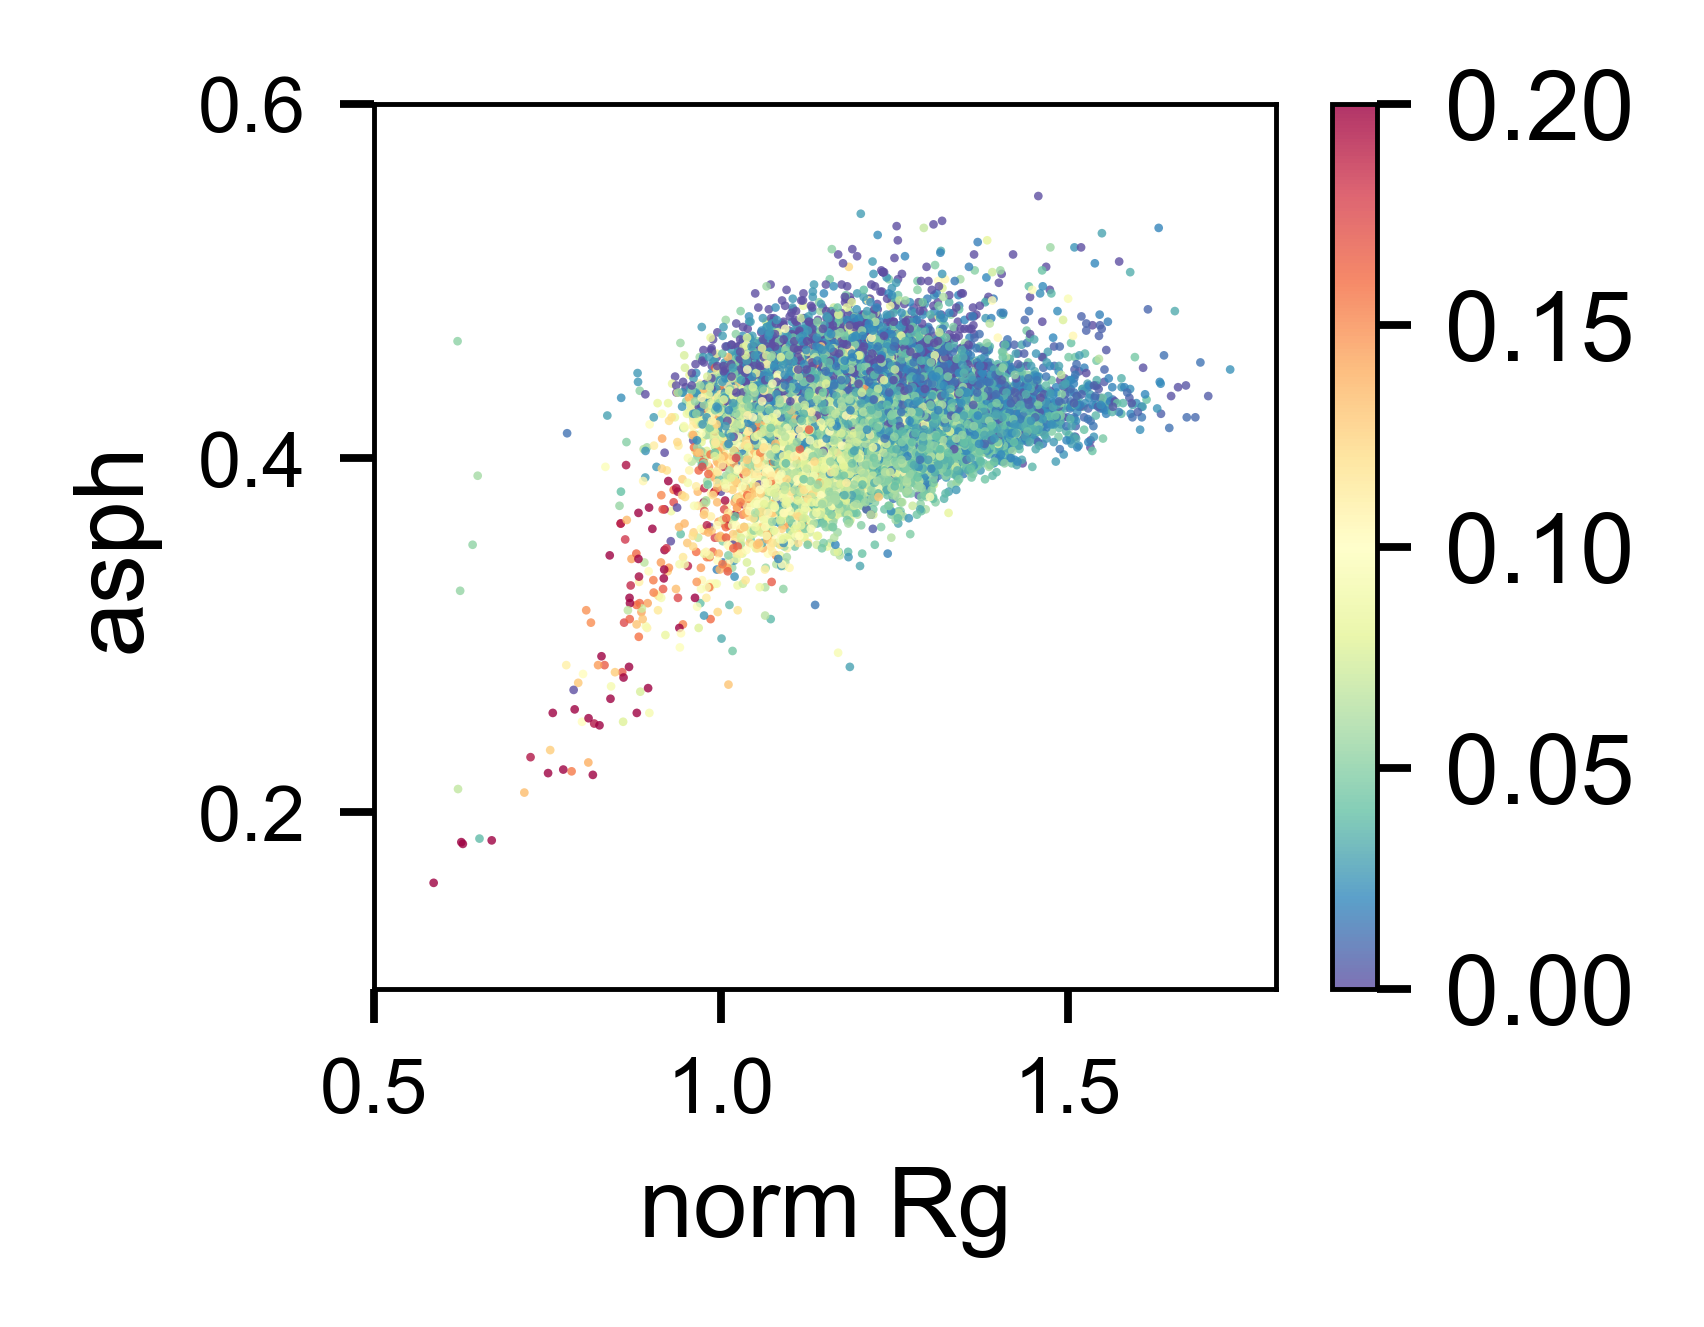

In [44]:
fig = figure(None, (2.5,2.), dpi=350)
plt.scatter(all_rg_norm, all_asph, c=all_aro, s=0.8, alpha=0.8, lw=0, cmap='Spectral_r', vmin=0.0, vmax=0.2, rasterized=True)


plt.xlim([0.5,1.8])
plt.ylim([0.1,0.6])
plt.xlabel('norm Rg', fontsize=10)
plt.ylabel('asph', fontsize=10)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

plt.colorbar()
plt.tight_layout()

with PdfPages('figures/rg_vs_re_colored_asph_v2.pdf') as pdf:
    pdf.savefig(fig, dpi=950)



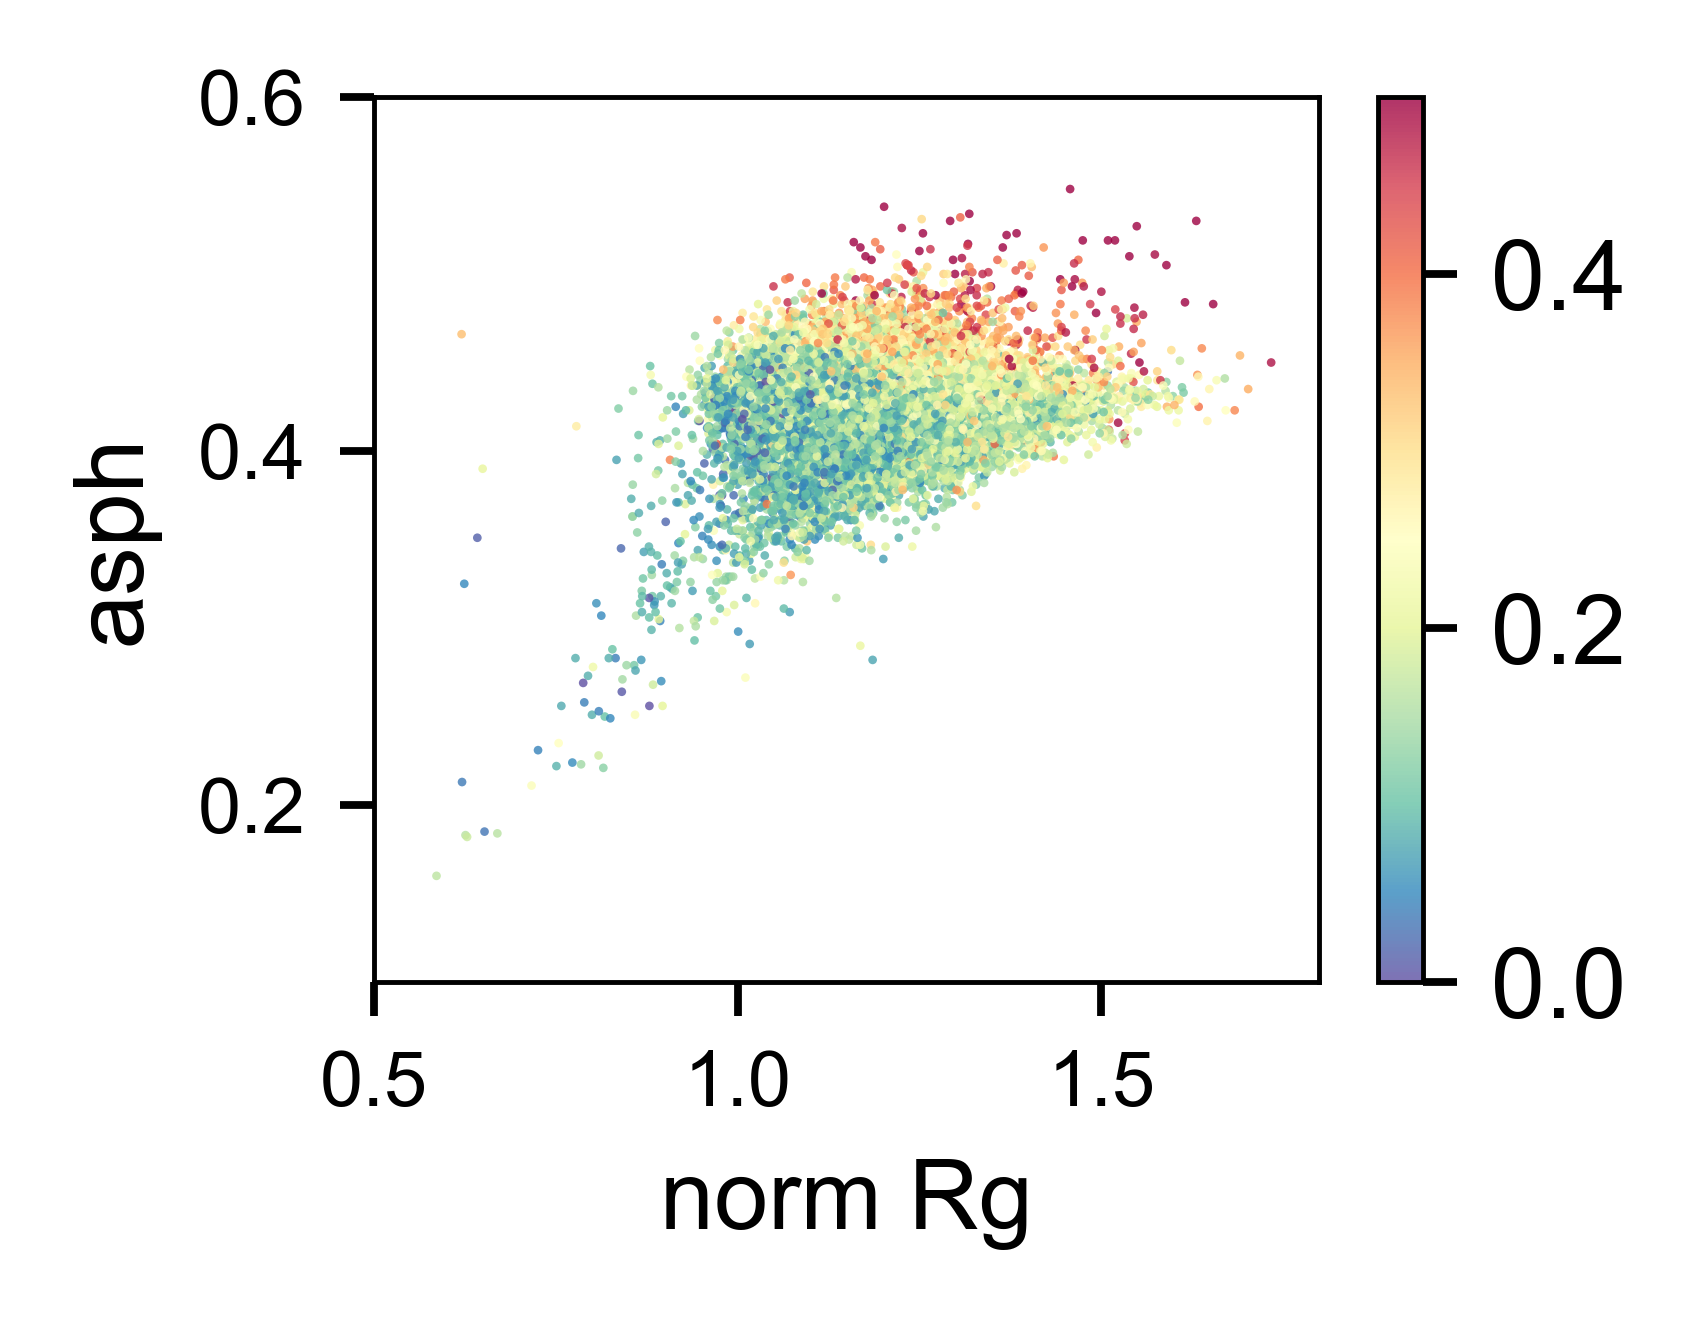

In [45]:
fig = figure(None, (2.5,2.), dpi=350)
plt.scatter(all_rg_norm, all_asph, c=all_abs_ncpr_pro, s=0.8, alpha=0.8, lw=0, cmap='Spectral_r', vmin=0.0, vmax=0.5, rasterized=True)


plt.xlim([0.5,1.8])
plt.ylim([0.1,0.6])
plt.xlabel('norm Rg', fontsize=10)
plt.ylabel('asph', fontsize=10)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

plt.colorbar()
plt.tight_layout()

with PdfPages('figures/rg_vs_re_colored_asph_proncpr.pdf') as pdf:
    pdf.savefig(fig, dpi=950)

